# Sentiment Analysis For Indonesian Dataset with SVC

## Import Library 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.utils import save_model, load_model

## Import Data

In [2]:
df = pd.read_csv("data/Indonesian_Sentiment_Twitter_Dataset_Labeled.csv", error_bad_lines=False, sep='\t')
df.head()

,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


In [3]:
df.shape

(10806, 2)

Data terdiri dari 10806 baris dan 2 kolom.

In [4]:
df.dtypes

sentimen     int64
Tweet       object
dtype: object

Tipe data telah sesuai.

In [5]:
df.isna().sum()

sentimen    0
Tweet       0
dtype: int64

Data telah bersih.

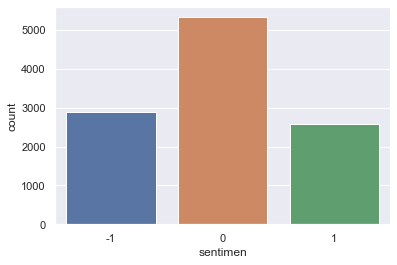

In [6]:
sns.countplot(df.sentimen);

In [7]:
df.sentimen.value_counts(normalize=True)

 0    0.492967
-1    0.267166
 1    0.239867
Name: sentimen, dtype: float64

Target variabel masih dapat dikatakan balanced.

## Cleaning 

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sw_indo = stopwords.words('indonesian')

Idealnya kita definisikan sendiri stopwords kita tergantung masalah yang sedang dihadapi. Namun, kali ini saya hanya akan menggunakan stopwords indonesia bawaan nltk.

In [9]:
def cleansing(text):
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 1 and word.isalpha()]
    word_list = [word for word in word_list if word not in punctuation]
    word_list = [word for word in word_list if word not in sw_indo]
    text = ' '.join(word_list)
    return text

In [10]:
df['Tweet'] = df.Tweet.apply(cleansing)

In [11]:
df.head()

,sentimen,Tweet
0,-1,lagu bosan save ni huhuhuhuhuhuhuhuhuhuuuuuuuu...
1,-1,lanjutkan diam kau mengerti kebersamaan meliba...
2,1,doa rezeki putus inna haa zaa larizquna maa la...
3,1,makasih loh ntar hasil sisanya
4,-1,faham jenis orang malaysia reti nak sangkut ho...


## Dataset Splitting

In [12]:
X = df.Tweet
y = df.sentimen

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8644,), (2162,), (8644,), (2162,))

## Modeling

In [13]:
from jcopml.tuning import grid_search_params as gsp
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning.space import Integer, Real
from sklearn.svm import SVC

In [14]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [15]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', SVC(max_iter=500))
])


model = RandomizedSearchCV(pipeline, gsp.svm_params, cv=10, n_iter=25, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:  5.0min finished


{'algo__gamma': 1.0, 'algo__C': 1.0}
0.6072420175844516 0.49409775743952045 0.49121184088806663


In [16]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score', ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__gamma,param_algo__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
22,3.020473,0.049310,0.349920,0.022886,1,1,"{'algo__gamma': 1.0, 'algo__C': 1.0}",0.490173,0.521387,0.484393,0.499422,0.476852,0.465278,0.519676,0.493056,0.497685,0.493056,0.494098,0.016371,1
1,2.908366,0.145879,0.337719,0.022792,1,1000,"{'algo__gamma': 1.0, 'algo__C': 1000.0}",0.445087,0.499422,0.461272,0.497110,0.495370,0.496528,0.503472,0.467593,0.480324,0.483796,0.482997,0.018381,2
8,2.844363,0.103041,0.331119,0.020721,1,10,"{'algo__gamma': 1.0, 'algo__C': 10.0}",0.436994,0.513295,0.470520,0.485549,0.495370,0.479167,0.489583,0.442130,0.480324,0.497685,0.479062,0.022684,3
3,2.776959,0.126489,0.322719,0.014807,0.1,1000,"{'algo__gamma': 0.1, 'algo__C': 1000.0}",0.423121,0.508671,0.478613,0.489017,0.487269,0.468750,0.496528,0.489583,0.472222,0.467593,0.478137,0.022056,4
24,2.817861,0.143315,0.321318,0.020066,0.1,10,"{'algo__gamma': 0.1, 'algo__C': 10.0}",0.469364,0.514451,0.440462,0.493642,0.472222,0.453704,0.471065,0.469907,0.476852,0.459491,0.472116,0.019473,5


## Evaluasi 

In [17]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix

In [18]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

          -1       0.48      0.71      0.57      2309
           0       0.67      0.75      0.71      4261
           1       0.98      0.20      0.33      2074

    accuracy                           0.61      8644
   macro avg       0.71      0.55      0.54      8644
weighted avg       0.69      0.61      0.58      8644


Test report
              precision    recall  f1-score   support

          -1       0.37      0.59      0.45       578
           0       0.58      0.66      0.62      1066
           1       0.58      0.03      0.06       518

    accuracy                           0.49      2162
   macro avg       0.51      0.43      0.38      2162
weighted avg       0.52      0.49      0.44      2162



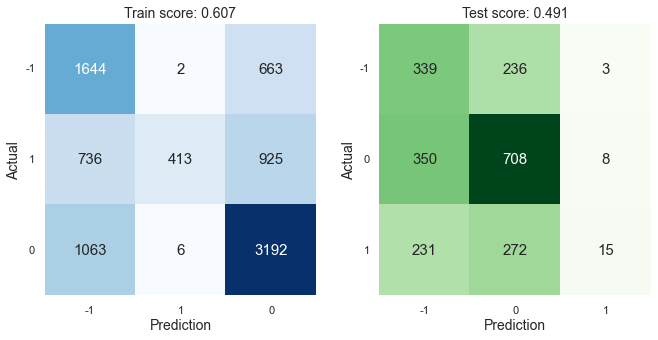

In [19]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

Dari hasil modeling menggunakan Support Vector Classifier (SVC) masih belum mendapatkan hasil yang baik. Selanjutnya saya akan mencoba melakukan teknik feature engineering yang lain untuk teks dan mencoba algoritma lain harapannya agar model bisa lebih baik lagi.